In [1]:
import os
import pickle
import datetime
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Probit
import matplotlib.pyplot as plt

In [ ]:
SAVE_PATH = './output/probit_regression'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [2]:
with open('./output/samples_capm.txt', 'rb') as f:
    capm_samples_dict = pickle.load(f)

capm_state_samples = capm_samples_dict['state_samples']
capm_sigma_samples = capm_samples_dict['sigma_samples']
capm_G_samples = capm_samples_dict['graph_samples']
capm_beta_samples = capm_samples_dict['beta_samples']
capm_tran_matrix_samples = capm_samples_dict['transition_matrix_samples']

In [3]:
with open('./output/samples_thr.txt', 'rb') as f:
    thr_samples_dict = pickle.load(f)

thr_state_samples = thr_samples_dict['state_samples']
thr_sigma_samples = thr_samples_dict['sigma_samples']
thr_G_samples = thr_samples_dict['graph_samples']
thr_beta_samples = thr_samples_dict['beta_samples']
thr_tran_matrix_samples = thr_samples_dict['transition_matrix_samples']

In [4]:
# identify systemic risk state
capm_idtf = np.mean(capm_state_samples) < 0.5
if capm_idtf:
    capm_labels = {0: "Low", 1: "High"}
    capm_high_risk_state_samples = capm_state_samples
else:
    capm_labels = {0: "High", 1: "Low"}
    capm_high_risk_state_samples = 1 - capm_state_samples
    
thr_idtf = np.mean(thr_state_samples) < 0.5
if thr_idtf:
    thr_labels = {0: "Low", 1: "High"}
    thr_high_risk_state_samples = thr_state_samples
else:
    thr_labels = {0: "High", 1: "Low"}
    thr_high_risk_state_samples = 1 - thr_state_samples

# high systemic risk probability
capm_high_risk_prob = np.mean(capm_high_risk_state_samples, axis=0)
thr_high_risk_prob = np.mean(thr_high_risk_state_samples, axis=0)

In [5]:
np.savetxt("./output/capm_high_risk_prob.txt", capm_high_risk_prob)
np.savetxt("./output/thr_high_risk_prob.txt", thr_high_risk_prob)

In [2]:
capm_high_risk_prob = np.loadtxt("./output/capm_high_risk_prob.txt")
thr_high_risk_prob = np.loadtxt("./output/thr_high_risk_prob.txt")

In [5]:
np.sum(thr_high_risk_prob>0.5)

894

In [3]:
trading_date = pd.DataFrame(np.loadtxt('./intermediate/trading_date.txt',dtype='str'),columns=['trading_date'])
trading_date.head()

,trading_date
0,2008-01-02
1,2008-01-03
2,2008-01-04
3,2008-01-07
4,2008-01-08


In [4]:
bond_yield = pd.read_excel("./input/bond_yield.xlsx", skiprows=2,
                           names=['trading_date', 'term', 'yield'])
bond_yield = pd.merge(trading_date, bond_yield, on='trading_date', how="left")
bond_yield.head()

,trading_date,term,yield
0,2008-01-02,0.00,2.0800
1,2008-01-02,0.08,2.5690
2,2008-01-02,0.17,3.0580
3,2008-01-02,0.25,3.3500
4,2008-01-02,0.50,3.4674


In [5]:
thr_month_yield = bond_yield[bond_yield.term == 0.25][['trading_date', 'yield']]
thr_month_yield = thr_month_yield.set_index('trading_date')
ten_year_yield = bond_yield[bond_yield.term == 10][['trading_date', 'yield']]
ten_year_yield = ten_year_yield.set_index("trading_date")
thirty_year_yield = bond_yield[bond_yield.term == 30][['trading_date', 'yield']]
thirty_year_yield = thirty_year_yield.set_index("trading_date")

In [6]:
term_spread = ten_year_yield - thr_month_yield
term_spread.columns = ['term_spread']
term_spread.head()

,term_spread
trading_date,
2008-01-02,1.0863
2008-01-03,1.1063
2008-01-04,1.0713
2008-01-07,1.0918
2008-01-08,1.0824


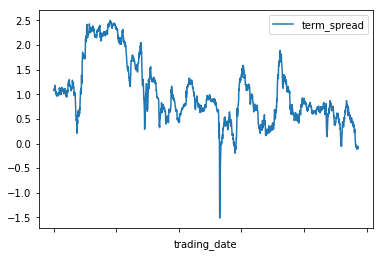

In [7]:
term_spread.plot()

In [8]:
corporate_bond_AAA = pd.read_excel("./input/corporate_bond_AAA.xls", skiprows=1,
                                   names=['trading_date', 'yield'])
corporate_bond_AAA['trading_date'] = corporate_bond_AAA.trading_date.apply(
    lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"))
corporate_bond_AAA = pd.merge(trading_date, corporate_bond_AAA, on='trading_date', how="left")
corporate_bond_AAA = corporate_bond_AAA.set_index('trading_date')
corporate_bond_AAA.head()

,yield
trading_date,
2008-01-02,5.839
2008-01-03,5.850
2008-01-04,5.850
2008-01-07,5.850
2008-01-08,5.850


In [9]:
corporate_bond_AA = pd.read_excel("./input/corporate_bond_A.xls", skiprows=1,
                                   names=['trading_date', 'yield'])
corporate_bond_AA['trading_date'] = corporate_bond_AA.trading_date.apply(
    lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"))
corporate_bond_AA = pd.merge(trading_date, corporate_bond_AA, on='trading_date', how="left")
corporate_bond_AA = corporate_bond_AA.set_index('trading_date')
corporate_bond_AA.head()

,yield
trading_date,
2008-01-02,6.1076
2008-01-03,6.1191
2008-01-04,6.1191
2008-01-07,6.1191
2008-01-08,6.1191


In [10]:
credit_spread =  corporate_bond_AA - ten_year_yield 
credit_spread.columns = ['credit_spread']
credit_spread.head()

,credit_spread
trading_date,
2008-01-02,1.6713
2008-01-03,1.6928
2008-01-04,1.7178
2008-01-07,1.7243
2008-01-08,1.7167


In [11]:
volatility = pd.read_excel("./input/volatility.xls", skiprows=0,
                           names=['trading_date', 'volatility'])
volatility['trading_date'] = volatility.trading_date.apply(
    lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"))
volatility['volatility'] = 100 * volatility['volatility']
volatility = pd.merge(trading_date, volatility, on='trading_date', how="left")
volatility = volatility.set_index('trading_date')
volatility.head()

,volatility
trading_date,
2008-01-02,1.9298
2008-01-03,1.8891
2008-01-04,1.8451
2008-01-07,1.8136
2008-01-08,1.7895


In [12]:
mkt = pd.read_excel("./input/mkt_index.xlsx", skiprows=5,
                           names=['trading_date', 'mkt'])
mkt['trading_date'] = mkt.trading_date.apply(
    lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"))
mkt['mkt'] = np.log(mkt.mkt).diff()
mkt = pd.merge(trading_date, mkt, on='trading_date', how="left")
mkt['mkt'] = mkt.mkt.interpolate(method='values').fillna(method='bfill')*100
mkt = mkt.set_index('trading_date')
mkt.head()

,mkt
trading_date,
2008-01-02,0.888299
2008-01-03,0.888299
2008-01-04,0.781041
2008-01-07,0.590783
2008-01-08,-0.126384


In [13]:
re = pd.read_excel("./input/re.xlsx", skiprows=7,
                           names=['trading_date',  're'])
re['trading_date'] = re.trading_date.apply(
    lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"))
re = pd.merge(trading_date, re, on='trading_date', how="left")
re['re'] = re.re.interpolate(method='values').fillna(method='bfill')
re = re.set_index('trading_date')
re.head()

,re
trading_date,
2008-01-02,106.11
2008-01-03,106.11
2008-01-04,106.11
2008-01-07,106.11
2008-01-08,106.11


In [14]:
repo = pd.read_excel("./input/repo.xls", skiprows=1,
                           names=['trading_date',  'yield'])
repo['trading_date'] = repo.trading_date.apply(
    lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"))
repo = pd.merge(trading_date, repo, on='trading_date', how="left")
repo = repo.set_index('trading_date')
repo = repo.fillna(method='bfill')
repo.head()

,yield
trading_date,
2008-01-02,4.2267
2008-01-03,4.2267
2008-01-04,4.2267
2008-01-07,4.2267
2008-01-08,4.2267


In [15]:
liquidity_spread = -repo + thr_month_yield
liquidity_spread.columns = ['liquidity_spread']
liquidity_spread.head()

,liquidity_spread
trading_date,
2008-01-02,-0.8767
2008-01-03,-0.9067
2008-01-04,-0.8967
2008-01-07,-0.9237
2008-01-08,-0.9067


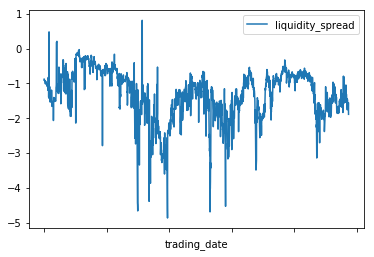

In [16]:
liquidity_spread.plot()
plt.show()

In [17]:
ur = pd.read_excel("./input/unemployment rate.xlsx", skiprows=4,
                           names=['trading_date', 'ur'])
ur['trading_date'] = ur.trading_date.apply(
    lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"))
ur = pd.merge(trading_date, ur, on='trading_date', how="left")
ur['ur'] = ur.ur.interpolate(method='values').fillna(method='bfill')
ur = ur.set_index('trading_date')
ur.head()

,ur
trading_date,
2008-01-02,4.0
2008-01-03,4.0
2008-01-04,4.0
2008-01-07,4.0
2008-01-08,4.0


In [27]:
cpi = pd.read_excel("./input/CPI.xlsx", skiprows=0,
                           names=['trading_date', 'cpi'])
cpi['trading_date'] = cpi.trading_date.apply(
    lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"))
cpi = pd.merge(trading_date, cpi, on='trading_date', how="left")
cpi['cpi'] = cpi.cpi.interpolate(method='values').fillna(method='bfill')
cpi = cpi.set_index('trading_date')
cpi.head()

,cpi
trading_date,
2008-01-02,2.6
2008-01-03,2.6
2008-01-04,2.6
2008-01-07,2.6
2008-01-08,2.6


In [19]:
ee = pd.read_excel("./input/effective exchange.xlsx", skiprows=4,
                           names=['trading_date', 'ee'])
ee['trading_date'] = ee.trading_date.apply(
    lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"))
ee = pd.merge(trading_date, ee, on='trading_date', how="left")
ee['ee'] = ee.ee.interpolate(method='values').fillna(method='bfill')
ee = ee.set_index('trading_date')
ee.head()

,ee
trading_date,
2008-01-02,94.73
2008-01-03,94.73
2008-01-04,94.73
2008-01-07,94.73
2008-01-08,94.73


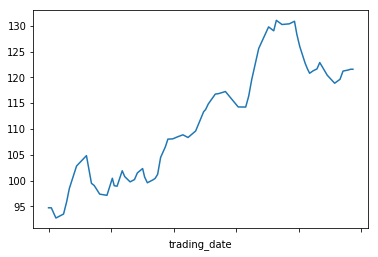

In [20]:
ee.ee.plot()

In [21]:
PE = pd.read_excel("./input/PE ratio.xlsx", skiprows=4,
                           names=['trading_date', 'PE'])
PE['trading_date'] = PE.trading_date.apply(
    lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"))
PE = pd.merge(trading_date, PE, on='trading_date', how="left")
PE = PE.set_index('trading_date')
PE.head()

,PE
trading_date,
2008-01-02,59.33
2008-01-03,59.89
2008-01-04,60.35
2008-01-07,60.76
2008-01-08,60.71


In [22]:
dr = pd.read_excel("./input/deposit reserve ratio.xlsx", skiprows=4,
                           names=['trading_date', 'dr'])
dr['trading_date'] = dr.trading_date.apply(
    lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"))
dr = pd.merge(trading_date, dr, on='trading_date', how="left")
dr = dr.set_index('trading_date')
dr.head()

,dr
trading_date,
2008-01-02,14.5
2008-01-03,14.5
2008-01-04,14.5
2008-01-07,14.5
2008-01-08,14.5


In [28]:
reg_data = term_spread.join(credit_spread)
reg_data = reg_data.join(liquidity_spread)
reg_data = reg_data.join(volatility)
reg_data = reg_data.join(ee)
reg_data = reg_data.join(cpi)
reg_data = reg_data.join(mkt)
reg_data = reg_data.join(re)
reg_data = reg_data.join(ur)
reg_data = reg_data.join(dr)
reg_data = reg_data.join(PE)
print reg_data.head()

              term_spread  credit_spread  liquidity_spread  volatility     ee  \
trading_date                                                                    
2008-01-02         1.0863         1.6713           -0.8767      1.9298  94.73   
2008-01-03         1.1063         1.6928           -0.9067      1.8891  94.73   
2008-01-04         1.0713         1.7178           -0.8967      1.8451  94.73   
2008-01-07         1.0918         1.7243           -0.9237      1.8136  94.73   
2008-01-08         1.0824         1.7167           -0.9067      1.7895  94.73   

              cpi       mkt      re   ur    dr     PE  
trading_date                                           
2008-01-02    2.6  0.888299  106.11  4.0  14.5  59.33  
2008-01-03    2.6  0.888299  106.11  4.0  14.5  59.89  
2008-01-04    2.6  0.781041  106.11  4.0  14.5  60.35  
2008-01-07    2.6  0.590783  106.11  4.0  14.5  60.76  
2008-01-08    2.6 -0.126384  106.11  4.0  14.5  60.71  


In [29]:
capm_ct = [1 if i > 0.5 else 0 for i in capm_high_risk_prob]
thr_ct = [1 if i > 0.5 else 0 for i in thr_high_risk_prob]
reg_data['capm_ct'] = capm_ct
reg_data['thr_ct'] = thr_ct
print reg_data.head()

              term_spread  credit_spread  liquidity_spread  volatility     ee  \
trading_date                                                                    
2008-01-02         1.0863         1.6713           -0.8767      1.9298  94.73   
2008-01-03         1.1063         1.6928           -0.9067      1.8891  94.73   
2008-01-04         1.0713         1.7178           -0.8967      1.8451  94.73   
2008-01-07         1.0918         1.7243           -0.9237      1.8136  94.73   
2008-01-08         1.0824         1.7167           -0.9067      1.7895  94.73   

              cpi       mkt      re   ur    dr     PE  capm_ct  thr_ct  
trading_date                                                            
2008-01-02    2.6  0.888299  106.11  4.0  14.5  59.33        1       1  
2008-01-03    2.6  0.888299  106.11  4.0  14.5  59.89        1       1  
2008-01-04    2.6  0.781041  106.11  4.0  14.5  60.35        1       1  
2008-01-07    2.6  0.590783  106.11  4.0  14.5  60.76        1     

In [33]:
capm_y = np.array(reg_data['capm_ct'])
thr_y = np.array(reg_data['thr_ct'])
capm_y = capm_y[1:]
thr_y = thr_y[1:]
x = np.array(reg_data[['term_spread', 'credit_spread', 'liquidity_spread','mkt',
                       'volatility','PE',  're','dr', 'ee','cpi', 'ur']])
x = x[:-1]

In [37]:
reg = Probit(capm_y, sm.add_constant(x[:,[0,2,3,4,5,6,7,8,9,10]]))
reg_fit = reg.fit()
print reg_fit.summary2()

Optimization terminated successfully.
         Current function value: 0.476113
         Iterations 6
                          Results: Probit
Model:              Probit           Pseudo R-squared: 0.286      
Dependent Variable: y                AIC:              2338.7658  
Date:               2018-10-04 18:21 BIC:              2402.5315  
No. Observations:   2433             Log-Likelihood:   -1158.4    
Df Model:           10               LL-Null:          -1622.6    
Df Residuals:       2422             LLR p-value:      4.9961e-193
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
--------------------------------------------------------------------
            Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const      16.9129     3.9010    4.3355   0.0000    9.2671   24.5587
x1         -0.1921     0.0962   -1.9959   0.

In [38]:
reg_fit.get_margeff().summary()

<table class="simpletable">
<caption>Probit Marginal Effects</caption>
<tr>
  <th>Dep. Variable:</th>    <td>y</td>   
</tr>
<tr>
  <th>Method:</th>         <td>dydx</td>  
</tr>
<tr>
  <th>At:</th>            <td>overall</td>
</tr>
</table>
<table class="simpletable">
<tr>
   <th></th>      <th>dy/dx</th>    <th>std err</th>      <th>z</th>      <th>P>|z|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>x1</th>  <td>   -0.0514</td> <td>    0.026</td> <td>   -2.000</td> <td> 0.046</td> <td>   -0.102</td> <td>   -0.001</td>
</tr>
<tr>
  <th>x2</th>  <td>   -0.0127</td> <td>    0.015</td> <td>   -0.826</td> <td> 0.409</td> <td>   -0.043</td> <td>    0.017</td>
</tr>
<tr>
  <th>x3</th>  <td>   -0.0114</td> <td>    0.005</td> <td>   -2.231</td> <td> 0.026</td> <td>   -0.021</td> <td>   -0.001</td>
</tr>
<tr>
  <th>x4</th>  <td>    0.1929</td> <td>    0.012</td> <td>   16.567</td> <td> 0.000</td> <td>    0.170</td> <td>    0.216</td>
</tr>
<tr>
  <th>x5</th>  <td>    0.0208</td> <td>    0.002</td> <td>    9.397</td> <td> 0.000</td> <td>    0.016</td> <td>    0.025</td>
</tr>
<tr>
  <th>x6</th>  <td>   -0.0344</td> <td>    0.004</td> <td>   -9.480</td> <td> 0.000</td> <td>   -0.042</td> <td>   -0.027</td>
</tr>
<tr>
  <th>x7</th>  <td>   -0.0291</td> <td>    0.008</td> <td>   -3.656</td> <td> 0.000</td> <td>   -0.045</td> <td>   -0.014</td>
</tr>
<tr>
  <th>x8</th>  <td>   -0.0036</td> <td>    0.001</td> <td>   -2.513</td> <td> 0.012</td> <td>   -0.006</td> <td>   -0.001</td>
</tr>
<tr>
  <th>x9</th>  <td>   -0.1017</td> <td>    0.020</td> <td>   -5.093</td> <td> 0.000</td> <td>   -0.141</td> <td>   -0.063</td>
</tr>
<tr>
  <th>x10</th> <td>   -0.2226</td> <td>    0.164</td> <td>   -1.358</td> <td> 0.174</td> <td>   -0.544</td> <td>    0.099</td>
</tr>
</table>

In [158]:
for i in range(0, x.shape[1]):
    reg_i = Probit(thr_y, sm.add_constant(x[:,7]))
    reg_i_fit = reg_i.fit()
    print reg_data.columns[i]
    print "系数： ",reg_i_fit.params[1]
    print "P值： ", reg_i_fit.pvalues[1]
    print "Pseudo R方： ", reg_i_fit.prsquared
    # print reg_i_fit.get_margeff().summary()
    print "\n"

Optimization terminated successfully.
         Current function value: 0.653208
         Iterations 4
term_spread
系数：  -3.0739718403790883
P值：  7.178692755809048e-06
Pseudo R方：  0.006315042296490048


Optimization terminated successfully.
         Current function value: 0.653208
         Iterations 4
credit_spread
系数：  -3.0739718403790883
P值：  7.178692755809048e-06
Pseudo R方：  0.006315042296490048


Optimization terminated successfully.
         Current function value: 0.653208
         Iterations 4
liquidity_spread
系数：  -3.0739718403790883
P值：  7.178692755809048e-06
Pseudo R方：  0.006315042296490048


Optimization terminated successfully.
         Current function value: 0.653208
         Iterations 4
volatility
系数：  -3.0739718403790883
P值：  7.178692755809048e-06
Pseudo R方：  0.006315042296490048


Optimization terminated successfully.
         Current function value: 0.653208
         Iterations 4
ee
系数：  -3.0739718403790883
P值：  7.178692755809048e-06
Pseudo R方：  0.006315042296490048


In [41]:
reg_data[['term_spread',  'liquidity_spread','mkt',
        'volatility','PE',  're','dr', 'ee','cpi', 'ur']].describe().to_csv(SAVE_PATH + '/variables.csv')

In [20]:
np.corrcoef(x.T)

array([[ 1.        , -0.13980844, -0.50605684,  0.31076509,  0.4343408 ,
         0.00143955],
       [-0.13980844,  1.        ,  0.38997431, -0.11352016, -0.7875025 ,
         0.03037824],
       [-0.50605684,  0.38997431,  1.        , -0.24102978, -0.34959983,
        -0.01313051],
       [ 0.31076509, -0.11352016, -0.24102978,  1.        ,  0.22228958,
        -0.01739471],
       [ 0.4343408 , -0.7875025 , -0.34959983,  0.22228958,  1.        ,
        -0.03864041],
       [ 0.00143955,  0.03037824, -0.01313051, -0.01739471, -0.03864041,
         1.        ]])

In [24]:
pd.DataFrame(np.corrcoef(x.T)).to_csv(SAVE_PATH + "/correlations.csv")

In [48]:
sm.tsa.stattools.adfuller(x[:, 4])

(-2.285131056766177,
 0.17680835359893066,
 23L,
 2409L,
 {'1%': -3.4330674270336785,
  '10%': -2.5674090892669166,
  '5%': -2.8627405248963482},
 -16002.98406266121)

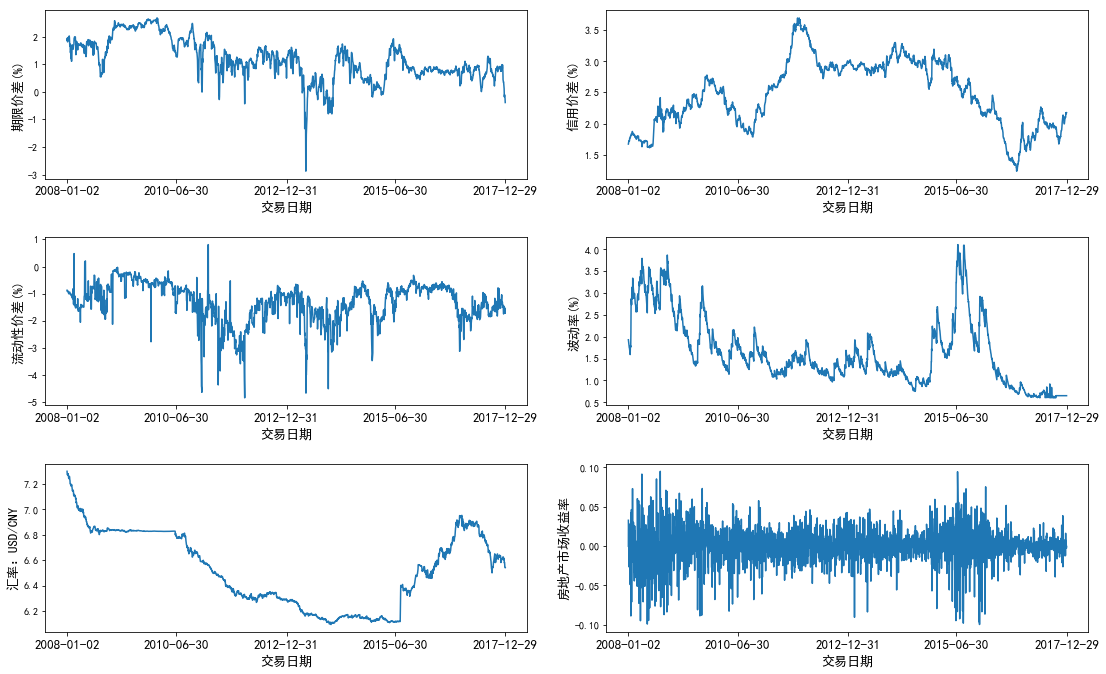

In [42]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
xticks = [0,  607,  1218,  1820, 2433]
fig = plt.figure(figsize=(16, 10))
plt.tight_layout(pad=3, h_pad=4, w_pad=4)
ax = fig.add_subplot(321)
ax.plot(x[:,0])
ax.set_xticks(xticks)
ax.set_xticklabels(np.array(trading_date.trading_date)[xticks],fontsize=13)
ax.set_xlabel(u'交易日期',fontsize=13)
ax.set_ylabel(u'期限价差(%)',fontsize=13)

plt.tight_layout(pad=3, h_pad=2, w_pad=3)
ax = fig.add_subplot(322)
ax.plot(x[:,1])
ax.set_xticks(xticks)
ax.set_xticklabels(np.array(trading_date.trading_date)[xticks],fontsize=13)
ax.set_xlabel(u'交易日期',fontsize=13)
ax.set_ylabel(u'信用价差(%)',fontsize=13)

plt.tight_layout(pad=3, h_pad=2, w_pad=3)
ax = fig.add_subplot(323)
ax.plot(x[:,2])
ax.set_xticks(xticks)
ax.set_xticklabels(np.array(trading_date.trading_date)[xticks],fontsize=13)
ax.set_xlabel(u'交易日期',fontsize=13)
ax.set_ylabel(u'流动性价差(%)',fontsize=13)

plt.tight_layout(pad=3, h_pad=2, w_pad=3)
ax = fig.add_subplot(324)
ax.plot(x[:,3])
ax.set_xticks(xticks)
ax.set_xticklabels(np.array(trading_date.trading_date)[xticks],fontsize=13)
ax.set_xlabel(u'交易日期',fontsize=13)
ax.set_ylabel(u'波动率(%)',fontsize=13)

plt.tight_layout(pad=3, h_pad=2, w_pad=3)
ax = fig.add_subplot(325)
ax.plot(x[:,4])
ax.set_xticks(xticks)
ax.set_xticklabels(np.array(trading_date.trading_date)[xticks],fontsize=13)
ax.set_xlabel(u'交易日期',fontsize=13)
ax.set_ylabel(u'汇率：USD/CNY',fontsize=13)

plt.tight_layout(pad=3, h_pad=2, w_pad=3)
ax = fig.add_subplot(326)
ax.plot(x[:,5])
ax.set_xticks(xticks)
ax.set_xticklabels(np.array(trading_date.trading_date)[xticks],fontsize=13)
ax.set_xlabel(u'交易日期',fontsize=13)
ax.set_ylabel(u'房地产市场收益率',fontsize=13)
plt.show()
fig.savefig(SAVE_PATH + "/variables.png")